## Домашняя работа № 3

### 1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта

### 2. при обучении моделей обязательно использовать кроссвалидацию

### 3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)

### 4. сделать выводы о том, какая модель справилась с задачей лучше других

### 5. (опциональный вопрос) какой график (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

### Разбивка на train/test/val

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix
import seaborn as sns
import itertools
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

#### Кейс - определение ССЗ

ссылка на соревнование - https://mlbootcamp.ru/ru/round/12/sandbox/

В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

 

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

In [2]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


Разделим наши данные на тренировочную и тестовую выборки

In [3]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], test_size = 0.20, random_state=29)

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [4]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [5]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[ 1.16519788, -0.04508665,  0.26743936, ...,  0.        ,
         0.        ,  1.        ],
       [-0.50003124,  0.07703438, -1.12469284, ...,  1.        ,
         1.        ,  1.        ],
       [-1.74905431, -0.77781279, -0.70705318, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.90972509,  0.6876395 , -0.28941352, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.44938823, -0.77781279,  0.05861953, ...,  0.        ,
         0.        ,  1.        ],
       [-0.57898084,  1.29824462, -0.42862674, ...,  0.        ,
         0.        ,  1.        ]])

Добавим классификатор и запустим кросс-валидацию

### LogisticRegression

In [6]:
classifier = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}±{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7827210279407977±0.006580039485963771


Посчитаем precision/recall/f_score

In [7]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.394814, F-Score=0.734, Precision=0.654, Recall=0.836


Нарисуем roc auc кривую (кстати, наверное неплохо бы ее вынести в отдельную функцию)

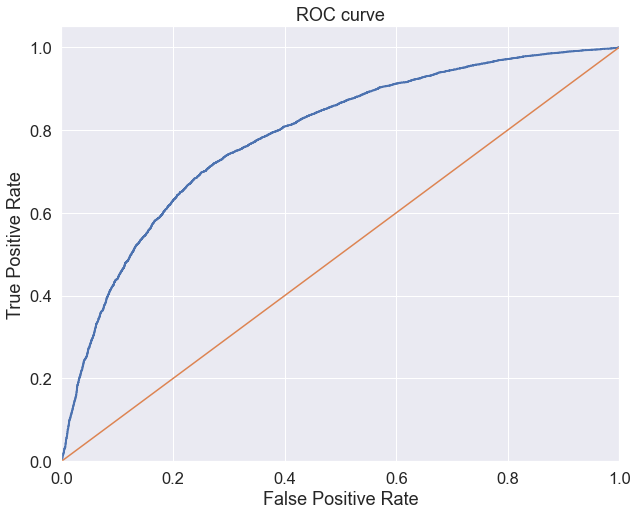

In [8]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [9]:
from sklearn.metrics import roc_auc_score, log_loss

roc_auc = roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])
log_loss = log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])

#Ваш код здесь
print("roc auc score: {}".format(roc_auc))
print("log loss score: {}".format(log_loss))

roc auc score: 0.7856323372291071
log loss score: 0.5761278218090113


Посомтрим на матрицу ошибок

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[3875 3101]
 [1153 5871]]


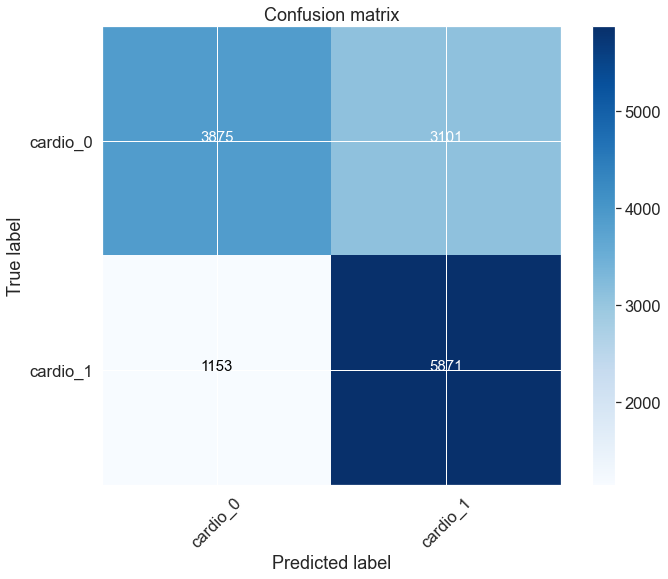

In [11]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>=thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Посчитаем FPR, TPR

In [12]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
FNR = FN/(TP+FN)
TPR, FPR, TNR, FNR

(0.8358485193621867,
 0.4445240825688073,
 0.5554759174311926,
 0.1641514806378132)

False Positive Rate довольно высокий ~ 0.45.

Это означает, что 45 процентов всех пациентов получат метку 1 при том, что они на самом деле здоровы

Хорошая ли модель у нас получилась? - ответ сильно зависит от внешних факторов (какое количество FP мы можем допустить)

In [13]:
# roc_auc, precision, recall, f_score
# mean, median, max, idf_mean
score_compare = pd.DataFrame({
    "method": ['log_reg'], 
    "roc_auc_score": [roc_auc], 
    "precision": [precision[ix]], 
    "recall": [recall[ix]], 
    "f_score": [fscore[ix]], 
    "TPR": [TPR], 
    "FPR": [FPR], 
    "TNR": [TNR], 
    "FNR": [FNR]
})
score_compare

,method,roc_auc_score,precision,recall,f_score,TPR,FPR,TNR,FNR
0,log_reg,0.785632,0.654369,0.835849,0.734059,0.835849,0.444524,0.555476,0.164151


### Support Vector Machine

In [19]:
from sklearn.svm import SVC

In [80]:
classifier = Pipeline([
    ('features', feats),
    ('classifier', SVC(random_state = 42, gamma="auto", probability=True)),
])

In [81]:
#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=5, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}±{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
#classifier.fit(X_train, y_train)
#y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7898046579775924±0.006221842289894133


In [82]:
#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('age',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='age')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('height',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='height')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('weight',
                                                 Pipeline(steps=[('selector',
                                        

In [83]:
y_score = classifier.predict_proba(X_test)[:, 1]

In [121]:
print(f'{y_test.values.shape}, {y_test.values.min()}, {y_test.values.max()}, {y_test.values.mean()}')

(14000,), 0, 1, 0.5017142857142857


In [123]:
print(f'{y_score.shape}, {y_score.min()}, {y_score.max()}, {y_score.mean()}')

(14000,), 1.589457199519751e-05, 0.9999997398356308, 0.4981385499666915


In [125]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=1.000000, F-Score=nan, Precision=0.000, Recall=0.000


<ipython-input-125-a6589924b8a7>:3: RuntimeWarning: invalid value encountered in true_divide
  fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)


In [124]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values[0:6442], y_score[0:6442])
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.416867, F-Score=0.743, Precision=0.699, Recall=0.792


### Домашнее задание

1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

### Ссылки

1. https://dyakonov.org/2017/07/28/auc-roc-площадь-под-кривой-ошибок/
2. https://en.wikipedia.org/wiki/Receiver_operating_characteristic